In [1]:
# IMPORTY
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import joblib
import re
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import os
from os import path
from PIL import Image

%matplotlib inline

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# SETUP (odpalić raz)
print("Pobieranie zasobów NLTK")
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

Pobieranie zasobów NLTK


True

In [2]:
# CZYTANIE PLIKÓW
try:
    df = pd.read_csv('spam_NLP.csv', sep=',', quotechar='"', names=['id', 'label', 'text'], skiprows=1)

    print("COŚ CZYTA")
    print(f"Wczytano wierszy: {len(df)}")

    df = df[df['label'].astype(str).isin(['0', '1'])]
    df['label'] = df['label'].astype(int).map({1: 'spam', 0: 'ham'})
    df.dropna(inplace=True)

except Exception as e:
    print(f"COŚ NIE CZYTA: {e}")

#print("\ninfo")
#df.info()
#print("\nhead")
#print(df.head())
print(df)

COŚ CZYTA
Wczytano wierszy: 5796
        id label                                               text
0        0  spam  Dear Homeowner,\n\n \n\nInterest Rates are at ...
1        1  spam  ATTENTION: This is a MUST for ALL Computer Use...
2        2  spam  This is a multi-part message in MIME format.\n...
3        3  spam  IMPORTANT INFORMATION:\n\n\n\nThe new domain n...
4        4  spam  This is the bottom line.  If you can GIVE AWAY...
...    ...   ...                                                ...
5791  5791   ham  I'm one of the 30,000 but it's not working ver...
5792  5792   ham  Damien Morton quoted:\n\n>W3C approves HTML 4 ...
5793  5793   ham  On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...
5794  5794   ham  Once upon a time, Manfred wrote :\n\n\n\n> I w...
5795  5795   ham  If you run Pick, and then use the "New FTOC" b...

[5796 rows x 3 columns]


In [3]:
# BRAKI DANYCH
print("--- BRAKI DANYCH ---")
print(df.isnull().sum())

# USUWANIE DUPLIKATÓW
print("\n--- USUWANIE DUPLIKATÓW ---")
initial_count = len(df)
df.drop_duplicates(inplace=True)
final_count = len(df)
print(f"Usunięto {initial_count - final_count} duplikatów. Zostało {final_count} unikalnych wiadomości.")

# DŁUGOŚĆ WIADOMOŚCI
df['length'] = df['text'].apply(len) # PO ZNAKACH
df['word_count'] = df['text'].apply(lambda x: len(str(x).split())) # PO SŁOWACH

# STATYSTYKI DŁUGOŚCI HAM/SPAM
print("\n--- STATYSTYKI DŁUGOŚCI HAM/SPAM ---")
print("\n-= ZNAKI =-")
print(df.groupby('label')['length'].describe())

print("\n-= SŁOWA =-")
print(df.groupby('label')['word_count'].describe())

# STATYSTYKI MIN/MAX WIADOMOŚCI
print("\n--- EKSTREMALNE WARTOŚCI ---")
# MIN
min_len = df['length'].min()
shortest_msg = df[df['length'] == min_len]['text'].iloc[0]
print(f"Najkrótsza wiadomość: {min_len} znaków, {len(shortest_msg.split())} słów.")
print(f"Treść: '{shortest_msg}'")

# MAX
max_len = df['length'].max()
longest_msg = df[df['length'] == max_len]['text'].iloc[0]
print(f"\nNajdłuższa wiadomość: {max_len} znaków, {len(longest_msg.split())} słów.")
print(f"Treść: '{longest_msg[:200]}...'") # Limit do 200 znaków

# ŚREDNIA
avg_len = df['length'].mean()
avg_words = df['word_count'].mean()
print(f"\nŚrednio: {avg_len:.2f} znaków | {avg_words:.2f} słów na wiadomość.")

# ROZKŁAD % HAM/SPAM
total = len(df)
spam_perc = (len(df[df['label']=='spam'])/total)*100
ham_perc = (len(df[df['label']=='ham'])/total)*100

print("\n--- ROZKŁAD % ---")
print(f"HAM: {ham_perc:.2f}% | SPAM: {spam_perc:.2f}%")

--- BRAKI DANYCH ---
id       0
label    0
text     0
dtype: int64

--- USUWANIE DUPLIKATÓW ---
Usunięto 0 duplikatów. Zostało 5796 unikalnych wiadomości.

--- STATYSTYKI DŁUGOŚCI HAM/SPAM ---

-= ZNAKI =-
        count         mean          std   min      25%     50%      75%  \
label                                                                     
ham    3900.0  1615.114359   3890.48116  54.0   545.75   987.0  1640.00   
spam   1896.0  5178.556435  10372.98178  36.0  1113.75  2543.5  5730.25   

            max  
label            
ham    110372.0  
spam   234358.0  

-= SŁOWA =-
        count        mean         std  min    25%    50%    75%      max
label                                                                   
ham    3900.0  232.994872  570.853287  1.0   73.0  140.0  242.0  14954.0
spam   1896.0  449.258439  720.896880  2.0  118.0  252.0  498.0  11620.0

--- EKSTREMALNE WARTOŚCI ---
Najkrótsza wiadomość: 36 znaków, 2 słów.
Treść: '.



ukqdrblkougooeoffnxsmbowei




'

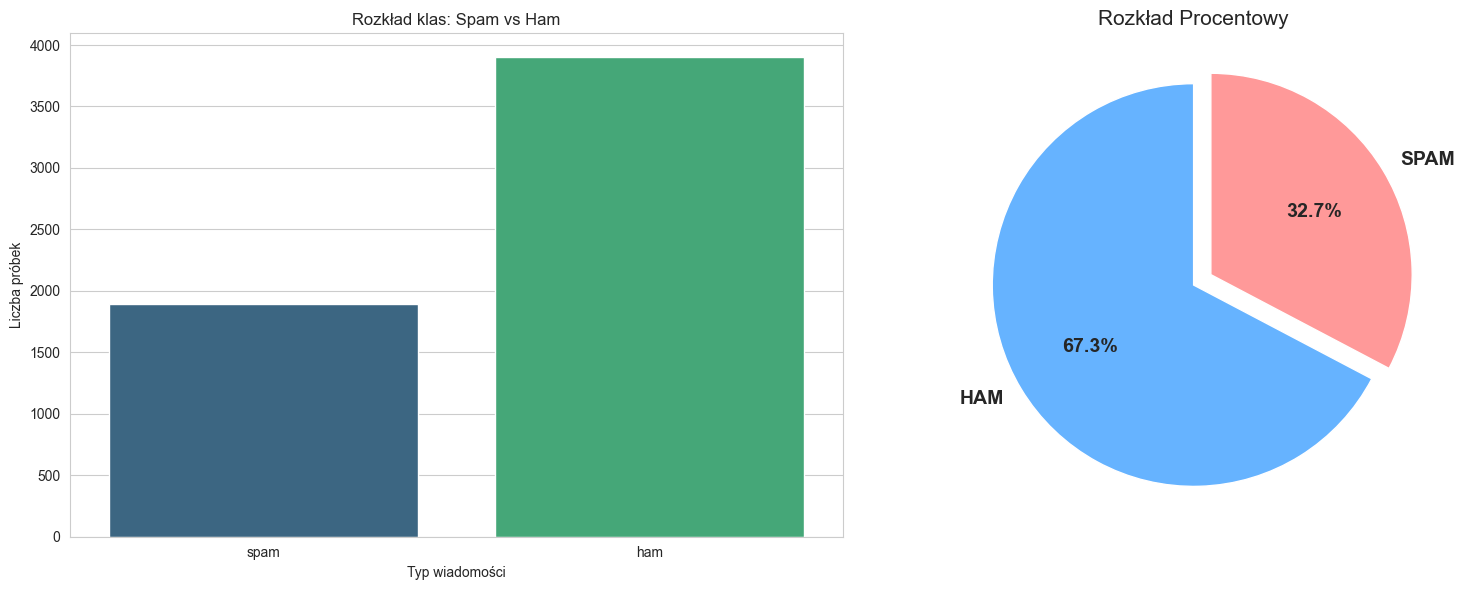

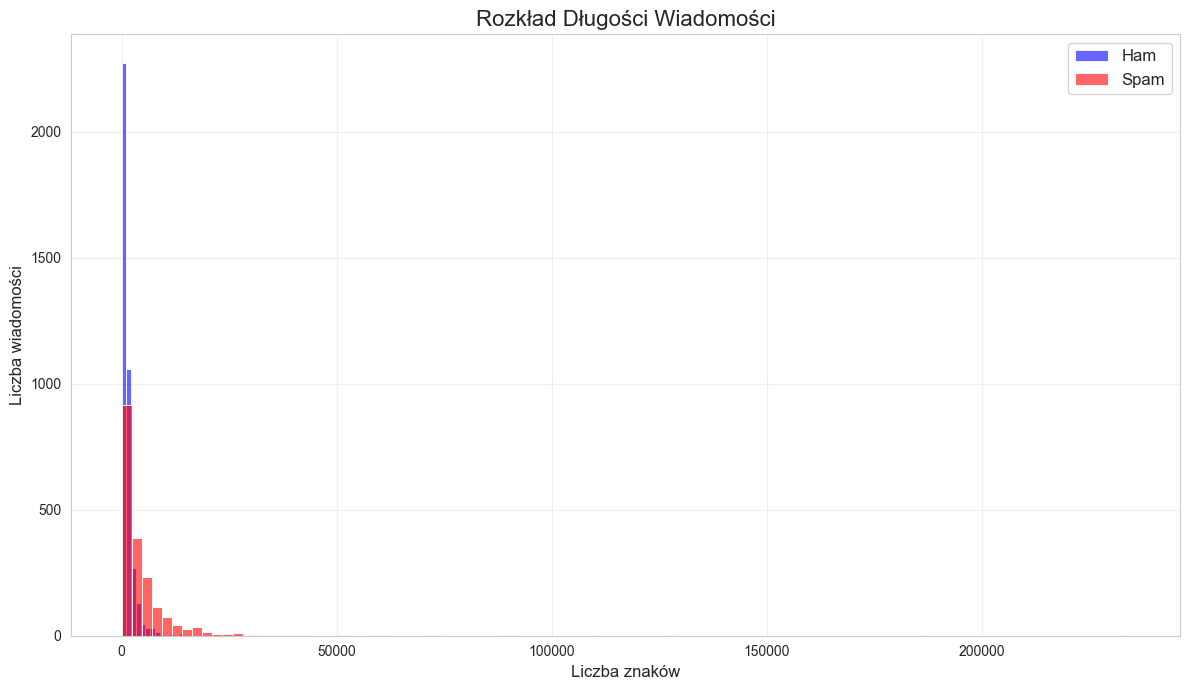

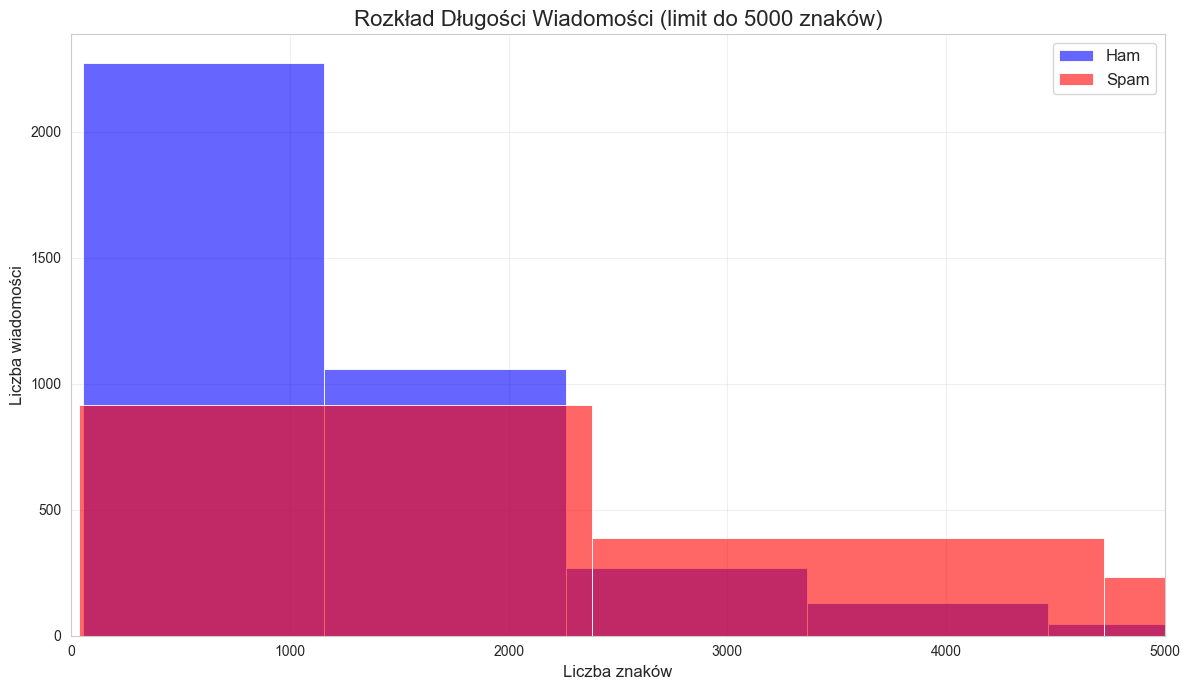

In [4]:
# WYKRESY ROZKŁADU SPAM/HAM I DŁUGOŚCI WIADOMOŚCI
sns.set_style("whitegrid")

# WYKRES 1 - ROZKŁAD SPAM/HAM LICZBOWY I %
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.countplot(x='label', data=df, hue='label', palette='viridis', legend=False, ax=axes[0])
axes[0].set_title('Rozkład klas: Spam vs Ham')
axes[0].set_xlabel('Typ wiadomości')
axes[0].set_ylabel('Liczba próbek')

counts = df['label'].value_counts()
axes[1].pie(counts, labels=['HAM', 'SPAM'], autopct='%1.1f%%',
            colors=['#66b3ff', '#ff9999'], startangle=90, explode=(0, 0.1),
            textprops={'fontsize': 14, 'weight': 'bold'})
axes[1].set_title('Rozkład Procentowy', fontsize=15)

plt.tight_layout()
plt.savefig('rozklad_klas.png')
plt.show()

# WYKRES 2 - ROZKŁAD DŁUGOŚCI WIADOMOŚCI
plt.figure(figsize=(12, 7))

sns.histplot(df[df['label'] == 'ham']['length'], bins=100, color='blue', alpha=0.6, label='Ham')
sns.histplot(df[df['label'] == 'spam']['length'], bins=100, color='red', alpha=0.6, label='Spam')

plt.title('Rozkład Długości Wiadomości', fontsize=16)
plt.xlabel('Liczba znaków', fontsize=12)
plt.ylabel('Liczba wiadomości', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dlugosc_wiadomosci.png')
plt.show()

# WYKRES 3 - ROZKŁAD DŁUGOŚCI WIADOMOŚCI LIMIT DO 5000 ZNAKÓW
plt.figure(figsize=(12, 7))

sns.histplot(df[df['label'] == 'ham']['length'], bins=100, color='blue', alpha=0.6, label='Ham')
sns.histplot(df[df['label'] == 'spam']['length'], bins=100, color='red', alpha=0.6, label='Spam')

plt.xlim(0, 5000)
plt.title('Rozkład Długości Wiadomości (limit do 5000 znaków)', fontsize=16)
plt.xlabel('Liczba znaków', fontsize=12)
plt.ylabel('Liczba wiadomości', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dlugosc_wiadomosci_limit_znakow.png')
plt.show()

In [5]:
# CZYSZCZENIE DANYCH (tokenizacja, lematyzacja, zamiana na małe litery, usuwanie znaków specjalnych, stopwords)
def preprocessing_pipeline(text):
    # SPRAWDZENIE CZY STRING
    if not isinstance(text, str):
        return ""

    # ZAMIANA NA MAŁE LITERY
    text = text.lower()
    #print("zamiana na małe litery: ", text[:100])

    # USUNIĘCIE ZNAKÓW SPECJALNYCH I CYFR
    text = re.sub(r'[^a-z\s]', '', text)
    #print("wstępne czyszczenie: ", text[:100])

    # TOKENIZACJA (dzielenie słów)
    words = text.split()
    #print("tokenizacja: ", words[:10])

    # USUWANIE STOPWORDS I LEMATYZACJA'
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    #print("czyszczenie: ", cleaned_words[:10])

    # ŁĄCZENIE W STRING
    return " ".join(cleaned_words)


# PRZETWORZENIE WSZYSTKICH WIADOMOŚCI
print("Preprocessing - START")
df['clean_text'] = df['text'].apply(preprocessing_pipeline)
print("Preprocessing - KONIEC\n")

print("PRZED:\n", df['text'].iloc[0])
print("PO:\n", df['clean_text'].iloc[0])

Preprocessing - START
Preprocessing - KONIEC

PRZED:
 Dear Homeowner,

 

Interest Rates are at their lowest point in 40 years!



We help you find the best rate for your situation by

matching your needs with hundreds of lenders!



Home Improvement, Refinance, Second Mortgage,

Home Equity Loans, and More! Even with less than

perfect credit!



This service is 100% FREE to home owners and new

home buyers without any obligation. 



Just fill out a quick, simple form and jump-start

your future plans today!





Visit http://61.145.116.186/user0201/index.asp?Afft=QM10













To unsubscribe, please visit:



http://61.145.116.186/light/watch.asp





PO:
 dear homeowner interest rate lowest point year help find best rate situation matching need hundred lender home improvement refinance second mortgage home equity loan even less perfect credit service free home owner new home buyer without obligation fill quick simple form jumpstart future plan today visit httpuserindexaspafftqm

In [6]:
# WEKTORYZACJA

# BAG OF WORDS - WAGA SŁOWA ZALEŻNA OD ILOŚCI WYSTĄPIEŃ
cv = CountVectorizer(max_features=5000) # OGRANICZENIE DO 5000 SŁÓW (max_features)
X_cv = cv.fit_transform(df['clean_text']).toarray()

print(f"Bag of Words gotowy. Kształt macierzy: {X_cv.shape}")

# TF-IDF (Term Frequency - Inverse Document Frequency) - TF: CZĘSTOTLIWOŚĆ WYSTĘPOWANIA SŁOWA W AKTUALNYM REKORDZIE (im częściej tym lepiej), IDF: CZĘSTOTLIWOŚĆ WYSTĘPOWANIA SŁOWA W RESZCIE DANYCH (im częściej tym gorzej)
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['clean_text']).toarray()

print(f"TF-IDF gotowy. Kształt macierzy: {X_tfidf.shape}")

# ETYKIETY
y = df['label'].map({'spam': 1, 'ham': 0})

# PODZIAŁ TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=2137, stratify=y)
print(f"\nDane podzielone. Trening: {X_train.shape}, Test: {X_test.shape}")

Bag of Words gotowy. Kształt macierzy: (5796, 5000)
TF-IDF gotowy. Kształt macierzy: (5796, 5000)

Dane podzielone. Trening: (4636, 5000), Test: (1160, 5000)


In [7]:
# TRENOWANIE I WYBÓR NAJLEPSZEGO MODELU

# PORÓWNYWANE MODELE
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "SVM (Liniowy)": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=2137),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=2137)
}

# WYNIKI
results = []

print("\n--- TRENING ---")

for name, model in models.items():
    print(f"\nTraining: {name}...")
    start_time = time.time()

    # TRENING
    model.fit(X_train, y_train)

    # TEST
    y_pred = model.predict(X_test)

    # CZAS TRENINGU
    end_time = time.time()
    duration = end_time - start_time

    # METRYKI
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"{name} zakończył trening w {duration: .2f}s.")
    print(f"Accuracy: {acc: .4f} | F1-Score: {f1: .4f}")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "Time (s)": duration
    })

# WYŚWIETLANIE WYNIKÓW
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1-Score', ascending=False) # Sortowanie od najlepszego

print("\n--- TABLICA WYNIKÓW ---")
print(results_df)

# ZMIENNA DLA NAJLEPSZEGO MODELU
best_model_name = results_df.iloc[0]['Model']
print(f"\nNAJLEPSZY MODEL WZGLĘDEM F1: {best_model_name}")

results_df.to_csv('model_results.csv', index=False)
print("Wyniki zapisane do 'model_results.csv'")


--- TRENING ---

Training: Naive Bayes...
Naive Bayes zakończył trening w  0.06s.
Accuracy:  0.9793 | F1-Score:  0.9675

Training: Logistic Regression...
Logistic Regression zakończył trening w  0.34s.
Accuracy:  0.9776 | F1-Score:  0.9646

Training: SVM (Liniowy)...
SVM (Liniowy) zakończył trening w  10.36s.
Accuracy:  0.9897 | F1-Score:  0.9840

Training: Random Forest...
Random Forest zakończył trening w  9.60s.
Accuracy:  0.9776 | F1-Score:  0.9657

Training: Gradient Boosting...
Gradient Boosting zakończył trening w  92.14s.
Accuracy:  0.9578 | F1-Score:  0.9322

--- TABLICA WYNIKÓW ---
                 Model  Accuracy  Precision    Recall  F1-Score   Time (s)
2        SVM (Liniowy)  0.989655   0.994609  0.973615  0.984000  10.363458
0          Naive Bayes  0.979310   0.994429  0.941953  0.967480   0.060857
3        Random Forest  0.977586   0.965699  0.965699  0.965699   9.603454
1  Logistic Regression  0.977586   0.997183  0.934037  0.964578   0.341395
4    Gradient Boosting  0

In [8]:
# --- TUNING HIPERPARAMETRÓW (Grid Search) ---
print(f"--- Tuning Hiperparametrów dla: {best_model_name} ---")

param_grids = {
    "Naive Bayes": {'alpha': [0.1, 0.5, 1.0]},
    
    "Logistic Regression": {'C': [0.1, 1, 10, 100]},
    
    "SVM (Liniowy)": {'C': [0.1, 1, 10]},

    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    },

    "Gradient Boosting": {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

if best_model_name == "SVM (Liniowy)":
    model_to_tune = SVC(kernel='linear', probability=True, random_state=2137)
    grid_params = param_grids["SVM (Liniowy)"]
    
elif best_model_name == "Logistic Regression":
    model_to_tune = LogisticRegression(random_state=2137, max_iter=1000)
    grid_params = param_grids["Logistic Regression"]
    
elif best_model_name == "Random Forest":
    model_to_tune = RandomForestClassifier(random_state=2137)
    grid_params = param_grids["Random Forest"]
    
elif best_model_name == "Gradient Boosting":
    model_to_tune = GradientBoostingClassifier(random_state=2137)
    grid_params = param_grids["Gradient Boosting"]
    
elif best_model_name == "Naive Bayes":
    model_to_tune = MultinomialNB()
    grid_params = param_grids["Naive Bayes"]
    
else:
    print("Nieznany model")

grid_search = GridSearchCV(model_to_tune, grid_params, cv=3, scoring='f1', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nTuning - KONIEC")
print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik F1 podczas tuningu: {grid_search.best_score_: .4f}")

# NAJLEPSZY MODEL PO TUNINGU
best_model_grdSrch = grid_search.best_estimator_

# DODATKOWY TEST
print("\n--- Ostateczny Test Tuningu ---")
y_pred_tuned = best_model_grdSrch.predict(X_test)
print(classification_report(y_test, y_pred_tuned))

--- Tuning Hiperparametrów dla: SVM (Liniowy) ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Tuning - KONIEC
Najlepsze parametry: {'C': 10}
Najlepszy wynik F1 podczas tuningu:  0.9834

--- Ostateczny Test Tuningu ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       781
           1       0.99      0.98      0.99       379

    accuracy                           0.99      1160
   macro avg       0.99      0.99      0.99      1160
weighted avg       0.99      0.99      0.99      1160



In [9]:
print("--- ZAPISYWANIE MODELU ---")

if 'tfidf' in locals() and 'best_model_grdSrch' in locals():
    try:
        # 1. Zapis Vectorizera
        joblib.dump(tfidf, 'vectorizer.pkl')
        vec_size = os.path.getsize('vectorizer.pkl') / 1024
        print(f"Vectorizer zapisany: 'vectorizer.pkl' (Rozmiar: {vec_size:.2f} KB)")

        # 2. Zapis Modelu
        joblib.dump(best_model_grdSrch, 'model.pkl')
        model_size = os.path.getsize('model.pkl') / 1024
        print(f"Model zapisany: 'model.pkl' (Rozmiar: {model_size:.2f} KB)")

        print("\n-= Zapisywanie zakończone =-")

    except Exception as e:
        print(f"Coś się nie zapisało: {e}")
else:
    print("Nie znaleziono zmiennych 'tfidf' lub 'best_model_grdSrch'.")

--- ZAPISYWANIE MODELU ---
Vectorizer zapisany: 'vectorizer.pkl' (Rozmiar: 183.21 KB)
Model zapisany: 'model.pkl' (Rozmiar: 33260.46 KB)

-= Zapisywanie zakończone =-


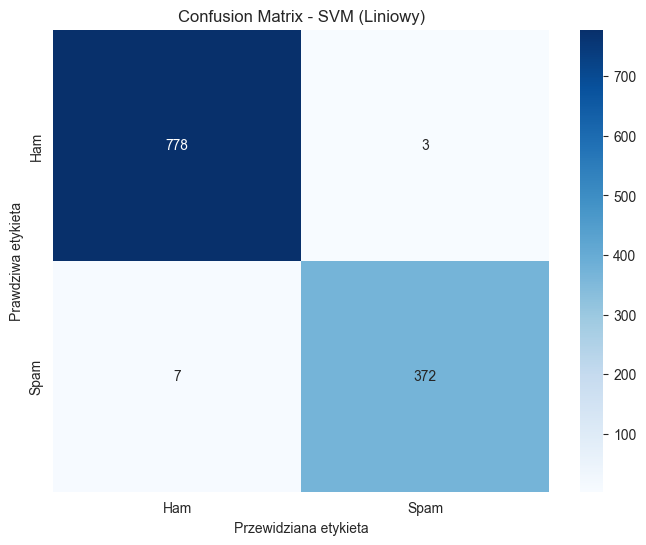

In [10]:
# MACIERZ POMYŁEK
best_model = models[best_model_name]

cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Prawdziwa etykieta')
plt.xlabel('Przewidziana etykieta')
plt.savefig('confusion_matrix.png')
plt.show()

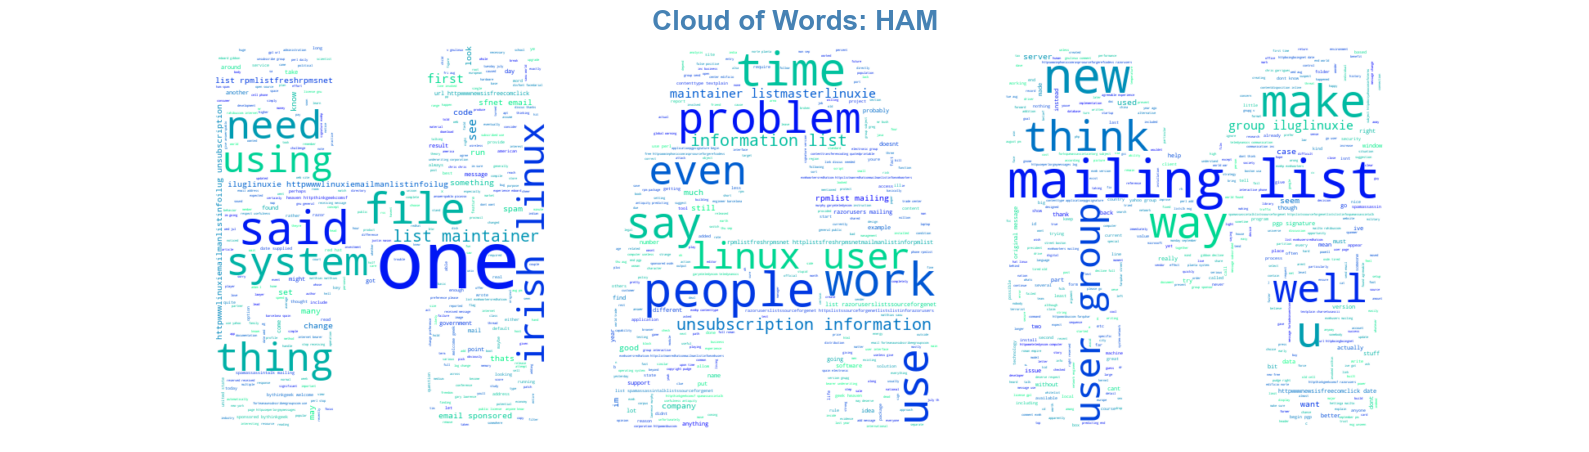

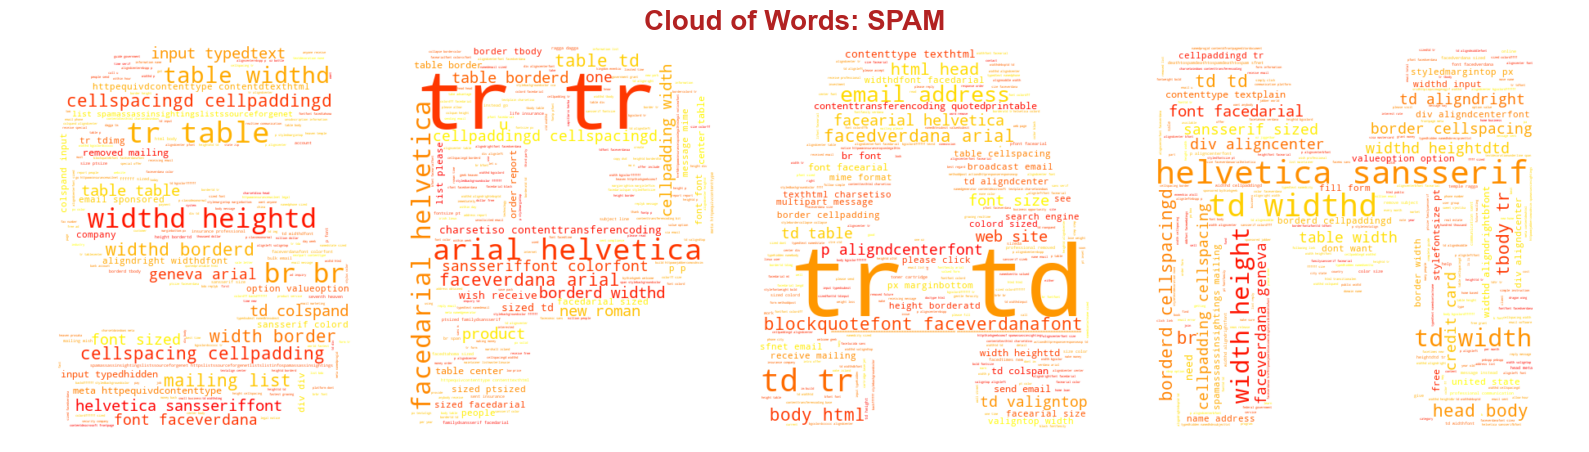

In [11]:
# CLOUD OF WORDS
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

try:
    mask_spam = np.array(Image.open(path.join(d, "SPAM.png")))
    try:
        mask_ham = np.array(Image.open(path.join(d, "HAM.png")))
    except FileNotFoundError:
        print("Nie znaleziono HAM.png, maska SPAM zostanie użyta do obu.")
        mask_ham = mask_spam

except FileNotFoundError:
    print("Nie znaleziono pliku SPAM.png.")
    exit()

MAX_WORDS = 3000

plt.figure(figsize=(16, 10))

# CoW HAM
ham_text = " ".join(df[df['label'] == 'ham']['clean_text'])

wc_ham = WordCloud(
    relative_scaling=0.4,
    background_color='white',
    colormap='winter',
    mask=mask_ham,
    contour_width=0,
    contour_color='steelblue',
    max_words=MAX_WORDS,
    random_state=42
).generate(ham_text)

plt.imshow(wc_ham, interpolation='bilinear')
plt.axis('off')
plt.title('Cloud of Words: HAM', fontsize=20, weight='bold', color='steelblue')

plt.tight_layout()
plt.savefig('cloudOfWords_HAM.png')
plt.show()

plt.figure(figsize=(16, 10))

# CoW SPAM
spam_text = " ".join(df[df['label'] == 'spam']['clean_text'])

wc_spam = WordCloud(
    relative_scaling=0.4,
    background_color='white',
    colormap='autumn',
    mask=mask_spam,
    contour_width=0,
    contour_color='firebrick',
    max_words=MAX_WORDS,
    random_state=42
).generate(spam_text)

plt.imshow(wc_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Cloud of Words: SPAM', fontsize=20, weight='bold', color='firebrick')

plt.tight_layout()
plt.savefig('cloudOfWords_SPAM.png')
plt.show()

--- INSPEKCJA MÓZGU MODELU ---
Model SVC używa 'coef_'

TOP 20 SŁÓW OZNACZAJĄCYCH SPAM (lub najważniejszych dla modelu):
                                                  słowa      waga
4890                                                 wi  2.307807
791                                               click  2.168679
3339                                             please  1.982310
390                                                  bc  1.797093
3711                                             remove  1.619822
1876                                               free  1.506881
1441                                              email  1.506576
2918                                              money  1.397931
3948                                               send  1.367991
1091                                             credit  1.329667
1641                                          facearial  1.321885
3158                                              order  1.288221
3480                 

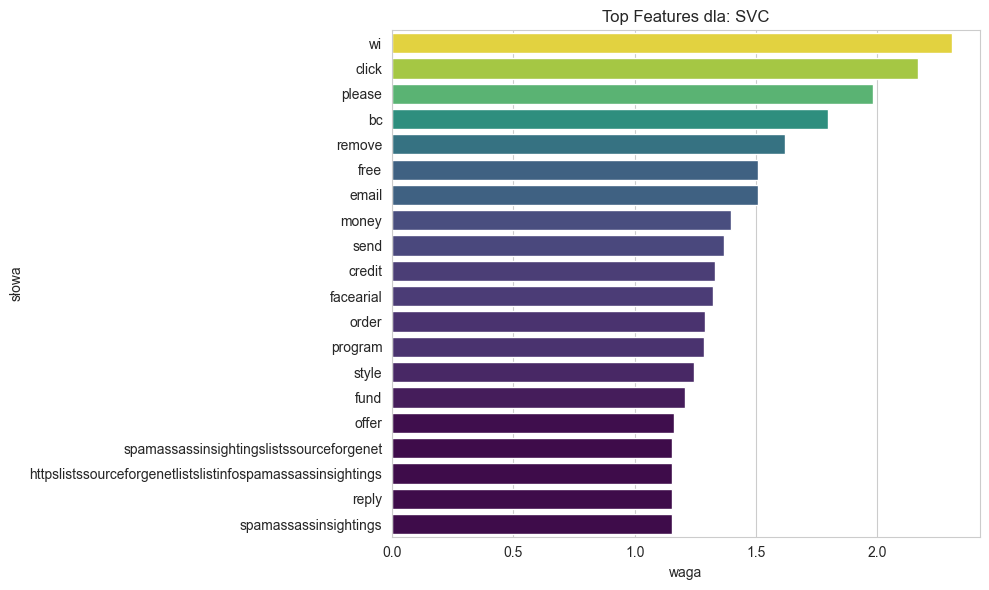

In [12]:
# POKAZUJE ILOŚĆ SŁÓW, PRZYDA SIĘ DO RAPORTU
print("--- INSPEKCJA MÓZGU MODELU ---")

trained_model = grid_search.best_estimator_
feature_names = tfidf.get_feature_names_out()
importance = None

# RANDOM FOREST, GRADIENT BOOSTING
if hasattr(trained_model, 'feature_importances_'):
    print(f"Model {type(trained_model).__name__} używa 'feature_importances_'")
    importance = trained_model.feature_importances_
    
# SVM, LOGISTIC REGRESSION)
elif hasattr(trained_model, 'coef_'):
    print(f"Model {type(trained_model).__name__} używa 'coef_'")
    importance = trained_model.coef_[0]
    
# NAIVE BAYES
elif hasattr(trained_model, 'feature_log_prob_'):
    print(f"Model {type(trained_model).__name__} używa 'feature_log_prob_'")
    spam_prob = trained_model.feature_log_prob_[1]
    ham_prob = trained_model.feature_log_prob_[0]
    importance = spam_prob - ham_prob
    
else:
    print("Jakiś błąd, skąd mam wiedzieć.")

if importance is not None:
    feat_importances = pd.DataFrame({'słowa': feature_names, 'waga': importance})

    feat_importances = feat_importances.sort_values(by='waga', ascending=False)

    print("\nTOP 20 SŁÓW OZNACZAJĄCYCH SPAM (lub najważniejszych dla modelu):")
    print(feat_importances.head(20))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='waga', y='słowa', data=feat_importances.head(20), hue='waga', palette='viridis', legend=False)
    plt.title(f'Top Features dla: {type(trained_model).__name__}')
    plt.tight_layout()
    plt.savefig('top_words_4_spam.png')
    plt.show()

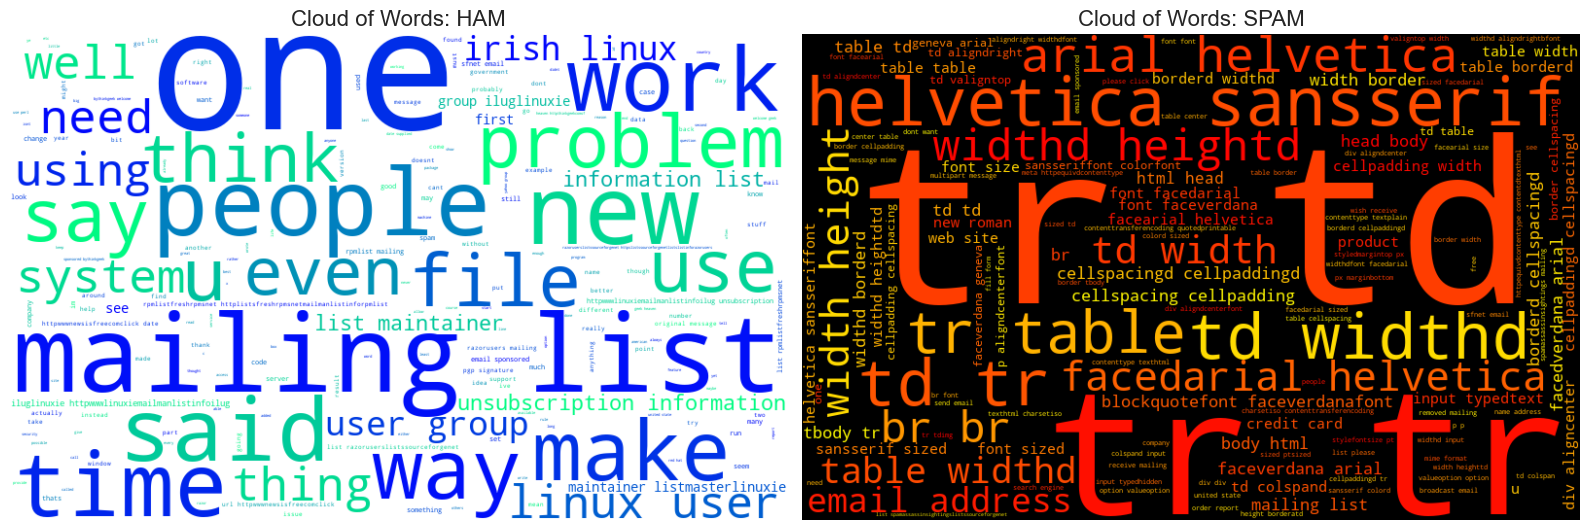

In [42]:
# CLOUD OF WORDS - STARE I BRZYDKIE

plt.figure(figsize=(16, 8))

# CoW HAM
plt.subplot(1, 2, 1) 
ham_text = " ".join(df[df['label'] == 'ham']['clean_text'])
wc_ham = WordCloud(width=800, height=500, background_color='white', colormap='winter').generate(ham_text)
plt.imshow(wc_ham, interpolation='bilinear')
plt.axis('off')
plt.title('Cloud of Words: HAM', fontsize=16)

# CoW SPAM
plt.subplot(1, 2, 2) 
spam_text = " ".join(df[df['label'] == 'spam']['clean_text'])
wc_spam = WordCloud(width=800, height=500, background_color='black', colormap='autumn').generate(spam_text)
plt.imshow(wc_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Cloud of Words: SPAM', fontsize=16)

plt.tight_layout()
plt.savefig('cloudOfWords.png')
plt.show()